In [1]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
config_var = 'SQLITE3_MULTI_GRID_RETINA'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [3]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.58 μs


((10000, 3), (2000, 3))


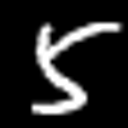
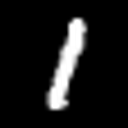
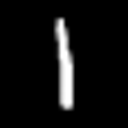
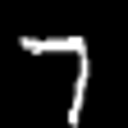
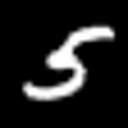
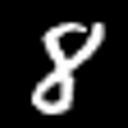
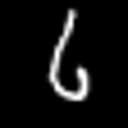
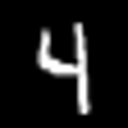
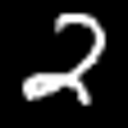
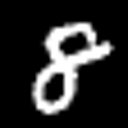
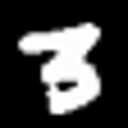
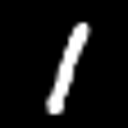
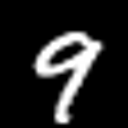
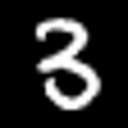
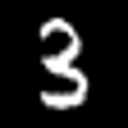
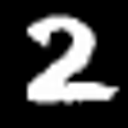

In [4]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [5]:
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, xp)

In [6]:
DIGITS = hdc(10)
DIGITS_NORM = hdc.normalize(DIGITS)

In [7]:
class CorticalColumn(object):
    def __init__(self):
        self.assoc_hdvs = HdvArray(hdc.N, xp, 100)
        i = self.assoc_hdvs.lease()
        self.assoc_hdvs.array[i] = hdc() # Deploy random assoc hdvs in order to avoid constant checks for active_len during training

In [8]:
COLUMNS = {}
COLUMNS = {-1: CorticalColumn()}
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(config.cortical_columns_count)))
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

df_test_results = pd.DataFrame(columns=['source_ds', 'test_run_id', 'test_image_id', 'true_value', 'engram_id', 'infer_value', 'sim'])

In [9]:
# TRAIN RUN
TRAIN_RUN_ID += 1
batch_size = 100

for column_id, column in tqdm(COLUMNS.items(), desc='Columns'):
    image_ids = RNG.choice(df_train_images.index.unique(), batch_size, replace=False)
    short_memory = defaultdict(lambda: defaultdict(list))

    # ENGRAMS (associations) mining
    for image_no, image_id in tqdm(enumerate(image_ids), leave=False, total=len(image_ids), desc='Mining'):
        image_value = df_train_images.loc[image_id]['value']
        target_hdv_index = int(image_value)
        target_hdv = DIGITS[target_hdv_index]
        
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                         params={'image_id': int(image_id), 'column_id': column_id}, 
                                         con=train_db_con)
        
        for image_encoding_hdv in df_image_encodings['hdv']:
            image_encoding_hdv = xp.frombuffer(image_encoding_hdv, dtype='b')
            assert image_encoding_hdv.shape == (hdc.N,)
            assoc_hdv_index = column.assoc_hdvs.lease()
            column.assoc_hdvs.array[assoc_hdv_index] = hdc.bind(image_encoding_hdv, target_hdv)
            short_memory[target_hdv_index]['source_hdvs'].append(image_encoding_hdv)
            short_memory[target_hdv_index]['assoc_hdv_indices'].append(assoc_hdv_index)

Columns:   0%|          | 0/1 [00:00<?, ?it/s]

Mining:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
for target_hdv_index, tab in short_memory.items():
    tab['source_hdvs'] = xp.array(tab['source_hdvs'])
    tab['assoc_hdv_indices'] = list(set(tab['assoc_hdv_indices'])) # get rid of duplicates
    assert len(tab['assoc_hdv_indices']) > 0
    tab['assoc_hdvs'] = xp.take(column.assoc_hdvs.array, tab['assoc_hdv_indices'], axis=0)
    print(f'{target_hdv_index} -> {tab['source_hdvs'].shape[0]}, {len(tab['assoc_hdv_indices'])}')

0 -> 451, 451
8 -> 369, 369
3 -> 492, 492
1 -> 533, 533
5 -> 369, 369
9 -> 451, 451
7 -> 369, 369
2 -> 492, 492
4 -> 287, 287
6 -> 287, 287


In [11]:
consolidation_cycles = 1000
    
# ENGRAMS (associations) consolidation
for target_hdv_index, tab in tqdm(short_memory.items(), leave=False, desc='Consolidation', total=len(short_memory)):
    assoc_hdvs_count = tab['assoc_hdvs'].shape[0]
    assert assoc_hdvs_count > 0
    random_tuples_count = assoc_hdvs_count * (assoc_hdvs_count - 1) // 2
    consolidation_cycles_ = min(random_tuples_count, consolidation_cycles)
    log.debug(f'[COL={column_id}] Begin consolidation for target HDV index={target_hdv_index}, assoc HDVs before={assoc_hdvs_count}, cycles={consolidation_cycles_}')
                
    for _ in tqdm(range(consolidation_cycles_), leave=False):
        if tab['assoc_hdvs'].shape[0] <= 1:
            pass # don't break to not break tqdm =)
        # Here we have all source HDVs associated with SINGLE taget_hdv via assoc_hdvs.
        # Our goal is to optimize associations by bundling them together,
        # but without breaking associations. The latter (breaking) could happen because
        # we could have several distinct clusters (say A, B, C) which map to X.
        # Should we bundle all these cluster into one megabundle then some of associations will get broken
        
        # 1. Pick two random assoc HDVs and merge together
        assert tab['assoc_hdvs'].shape[0] > 1
        assoc_hdv_indices_raw = list(range(tab['assoc_hdvs'].shape[0]))
        assoc_hdv_indices_to_merge = RNG.choice(assoc_hdv_indices_raw, 2, replace=False)
        assoc_hdv_indices_to_take = set(assoc_hdv_indices_raw) - set(assoc_hdv_indices_to_merge)
        index_where_to_place_bundle = 0
        assoc_hdv_indices_to_take = [index_where_to_place_bundle] + list(assoc_hdv_indices_to_take)
        new_assoc_hdvs = xp.take(tab['assoc_hdvs'], assoc_hdv_indices_to_take, axis=0)
        new_assoc_hdvs[index_where_to_place_bundle] = hdc.bundle(tab['assoc_hdvs'][assoc_hdv_indices_to_merge[0]], tab['assoc_hdvs'][assoc_hdv_indices_to_merge[1]])
        log.debug(f'[COL={column_id}] Consolidation target HDV index={target_hdv_index}, assocs={tab['assoc_hdvs'].shape[0]}, merge {assoc_hdv_indices_to_merge[0]} with {assoc_hdv_indices_to_merge[1]}')

        # 2. Check that association invariant still holds place for all source HDVs. Commit or rollback merge accordingly
        # assoc_results = xp.einsum('ij,kj->ikj', tab['source_hdvs'], new_assoc_hdvs, dtype='b') # batch bind (map) source hdvs via new assoc_hdvs
        # # all source hdvs still should get lead to the same SINGLE target_hdv via assoc hdvs
        # assoc_results_shape = assoc_results.shape
        # assoc_results = assoc_results.reshape(-1, hdc.N)
        # assoc_results_norm = hdc.normalize(assoc_results)
        # target_hdv = DIGITS_NORM[target_hdv_index]
        # digit_proximity = assoc_results_norm @ target_hdv
        # digit_proximity = digit_proximity.reshape(assoc_results_shape[0], assoc_results_shape[1])

        # Equivalent non-efficient, but more comprehensible and less memory-demanding core
        digit_proximity2 = xp.zeros((tab['source_hdvs'].shape[0], tab['assoc_hdvs'].shape[0]))
        
        for source_hdv_index, source_hdv in enumerate(tab['source_hdvs']):
            assoc_results2 = tab['assoc_hdvs'] * source_hdv # map source hdv via multiple assoc_hdvs
            assoc_results2_norm = hdc.normalize(assoc_results2)
            digit_proximity2_for_source_hdv = assoc_results2_norm @ DIGITS_NORM[target_hdv_index] # how close is mapped source hdv to target HDV under each assoc HDV?
            digit_proximity2[source_hdv_index] = digit_proximity2_for_source_hdv

        # assert xp.allclose(digit_proximity, digit_proximity2)
        digit_proximity = digit_proximity2

        if xp.any(xp.max(digit_proximity, axis=1) < COS_SIM_THRESHOLD):
            # We broke some associations. Rollback
            log.debug(f'[COL={column_id}] Consolidation target HDV index={target_hdv_index}, merge of {assoc_hdv_indices_to_merge[0]} with {assoc_hdv_indices_to_merge[1]} is BREAKING')
            pass
        else:
            # We didn't break any associations. Replace tab['assoc_hdvs'] with more compact version
            log.debug(f'[COL={column_id}] Consolidation target HDV index={target_hdv_index}, merge of {assoc_hdv_indices_to_merge[0]} with {assoc_hdv_indices_to_merge[1]} is OK')
            tab['assoc_hdvs'] = new_assoc_hdvs

    log.debug(f'[COL={column_id}] End consolidation for target HDV index={target_hdv_index}, assoc HDVs before={assoc_hdvs_count}, after={tab['assoc_hdvs'].shape[0]}, reduced by {assoc_hdvs_count - tab['assoc_hdvs'].shape[0]} ({1 - tab['assoc_hdvs'].shape[0] / assoc_hdvs_count:.2f}%)')

Consolidation:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
for target_hdv_index, tab in short_memory.items():
    print(f'{target_hdv_index} -> {tab['source_hdvs'].shape[0]}, {len(tab['assoc_hdvs'])}')

0 -> 451, 31
8 -> 369, 21
3 -> 492, 33
1 -> 533, 22
5 -> 369, 86
9 -> 451, 16
7 -> 369, 24
2 -> 492, 44
4 -> 287, 10
6 -> 287, 6


In [30]:
column.assoc_hdvs.clear()

for tab in short_memory.values():
    for assoc_hdv in tab['assoc_hdvs']:
        index = column.assoc_hdvs.lease()
        column.assoc_hdvs.array[index] = assoc_hdv

column.assoc_hdvs.len

293


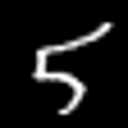

In [13]:
images = []
captions = []

if COLUMN.engrams.keys():
    random_engram_i = RNG.choice(list(COLUMN.engrams.keys()))
    image_ids = COLUMN.engram_to_image_ids[random_engram_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_engram_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))

images = images[:32]
captions = captions[:32]
display_images_grid(images, captions=captions, col_count=8)

In [73]:
# TEST RUN
TEST_RUN_ID += 1
count = 1000
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)
df_inference_results = pd.DataFrame(columns=['column_id', 'image_id', 'image_encoding_index', 'inference_vector'])

for image_id in tqdm(test_image_ids):
    column_inference_results_tab = defaultdict(list)
    
    image_value = test_run_source[0].loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                     params={'image_id': int(image_id), 'column_id': column_id}, 
                                     con=test_run_source[1])
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = list(map(lambda h: xp.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
    digits_proximities = []

    for image_encoding_index, image_encoding_hdv in enumerate(image_encoding_hdvs):
        assoc_results = column.assoc_hdvs.array_active * image_encoding_hdv
        assoc_results_norm = hdc.normalize(assoc_results)
        digits_proximity = assoc_results_norm @ DIGITS_NORM.T
        digits_proximity[digits_proximity < COS_SIM_THRESHOLD] = 0
        digits_proximity = xp_array_from_gpu(xp.sum(digits_proximity, axis=0))
        digits_proximities.append(digits_proximity)

    digits_proximities = np.sum(digits_proximities, axis=0) # reduce to just a vector
    digits_probabilities = np.exp(digits_proximities) / np.exp(digits_proximities).sum() # turn to probabilties
    # column_inference_results_tab['column_id'].append(column_id)
    # column_inference_results_tab['image_id'].append(image_id)
    # # column_inference_results_tab['image_encoding_index'].append(image_encoding_index)
    # column_inference_results_tab['inference_vector'].append(np.exp(digits_proximities) / np.exp(digits_proximities).sum())
    
    # df_inference_results = pd.concat([df_inference_results, pd.DataFrame(column_inference_results_tab)])

    digit_index = -1
    
    if np.any(digits_probabilities > 0):
        digit_index = RNG.choice(DIGITS.shape[0], p=digits_probabilities)

    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_id'].append(digit_index)
    test_result_rows['infer_value'].append(str(digit_index))
    test_result_rows['sim'].append(COS_SIM_THRESHOLD if digit_index != -1 else 0)
    

assert set(test_result_rows.keys()) == set(df_test_results.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
concat_list = [df_test_results] if len(df_test_results) > 0 else []
concat_list.append(df_test_results_for_run)
df_test_results = pd.concat(concat_list, ignore_index=True)

    
        

    

    
    # image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
    # image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

    

    # cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
    # cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
    # cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
    
    # assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
    # engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

    # if engram_ids_by_match_score.shape[0] > 0:
    #     engram_id = engram_ids_by_match_score[0]
    #     cos_sim_value = cos_sim_vector[engram_id]

    #     # if cos_sim_value >= COS_SIM_THRESHOLD:
    #     if cos_sim_value > 0:
    #         engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
    #         assert len(engram_image_ids) > 0
    #         engram_image_id = next(iter(engram_image_ids))
    #         engram_image_value = df_train_images.loc[engram_image_id]['value']
    #         max_cos_sim_index = engram_id
    #         max_similar_engram_image_value = engram_image_value
    #         max_cos_sim = cos_sim_value
    
    # test_result_rows['source_ds'].append(test_run_source[2])
    # test_result_rows['test_run_id'].append(TEST_RUN_ID)
    # test_result_rows['test_image_id'].append(image_id)
    # test_result_rows['true_value'].append(image_value)
    # test_result_rows['engram_id'].append(max_cos_sim_index)
    # test_result_rows['infer_value'].append(max_similar_engram_image_value)
    # test_result_rows['sim'].append(max_cos_sim)
    

# assert set(test_result_rows.keys()) == set(df_test_results.columns)
# df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
# concat_list = [df_test_results] if len(df_test_results) > 0 else []
# concat_list.append(df_test_results_for_run)
# df_test_results = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

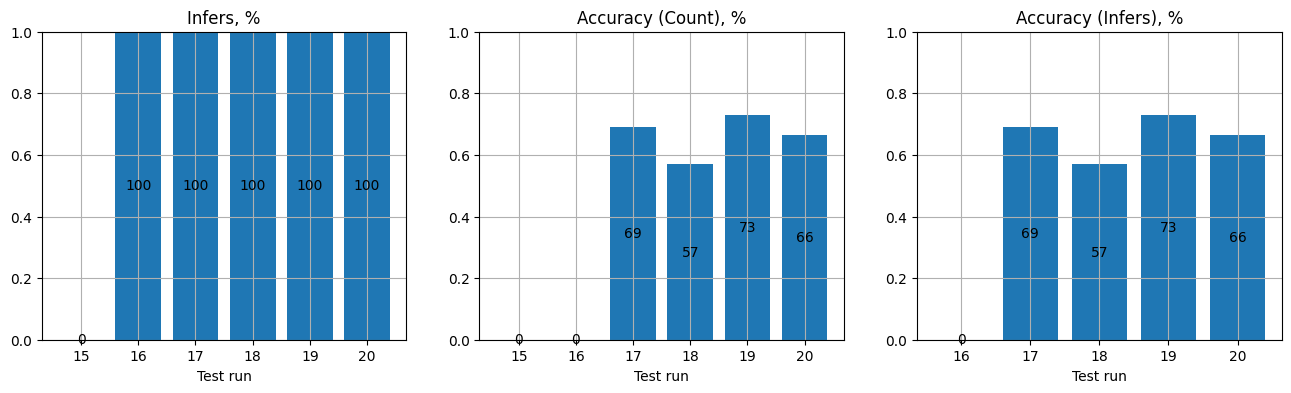

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,
15,100,0,0,0.0,0.000,NaN
16,100,100,0,1.0,0.000,0.000
17,100,100,69,1.0,0.690,0.690
18,100,100,57,1.0,0.570,0.570
19,100,100,73,1.0,0.730,0.730
20,1000,1000,664,1.0,0.664,0.664


In [74]:
df_test_results2 = df_test_results.copy()
df_test_results2['is_infer'] = df_test_results2['engram_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [17]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
test_run_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image_value = test_run_source[0].loc[incorrect_infer_image_id]['value']

df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'engram_id', 'engram_value', 'sim'])
df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_run_source[1])
assert len(df_image_encodings) > 0
image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image

assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

for pos, engram_id in enumerate(engram_ids_by_match_score):
    cos_sim_value = cos_sim_vector[engram_id]

    if cos_sim_value <= 0:
        break
        
    engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
    assert len(engram_image_ids) > 0
    engram_image_id = next(iter(engram_image_ids))
    engram_image_value = df_train_images.loc[engram_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, engram_id, engram_image_value, cos_sim_value]

df_x.sort_values(by='sim', ascending=False).head(10)

,test_run_id,test_image_id,true_value,engram_id,engram_value,sim
0,1,100002322,5,79,3,3.862693
1,1,100002322,5,20,8,3.840800
2,1,100002322,5,233,5,3.744116
3,1,100002322,5,200,5,3.571549
4,1,100002322,5,237,5,3.424872
5,1,100002322,5,1,5,3.314627
6,1,100002322,5,47,3,3.269252
7,1,100002322,5,163,3,3.015236
8,1,100002322,5,196,5,2.974074
9,1,100002322,5,2,3,2.696484



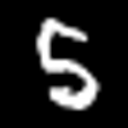

In [18]:
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image = Image.open(io.BytesIO(image_data))
label = test_run_source[0].loc[incorrect_infer_image_id]['value']
display_images([image], captions=[label])

In [19]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [20]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [21]:
df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']

np.int64(1)

In [22]:
incorrect_infer_row_index

np.int64(396)